In [0]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [0]:
from pathlib import Path
from IPython.core.debugger import set_trace
from fastai import datasets
import pickle, gzip, math, torch, matplotlib as mpl
import matplotlib.pyplot as plt
from torch import tensor
import operator
from torch.nn import init
from torch import nn
import torch.nn.functional as F
from functools import partial
from torch import optim

MNIST_URL='http://deeplearning.net/data/mnist/mnist.pkl'


def test(a,b,cmp,cname=None):
    if cname is None: cname=cmp.__name__
    assert cmp(a,b),f"{cname}:\n{a}\n{b}"

def test_eq(a,b): test(a,b,operator.eq,'==')

def near(a,b): return torch.allclose(a, b, rtol=1e-3, atol=1e-5)

def test_near(a,b): test(a,b,near)  
  
def get_data():
    path = datasets.download_data(MNIST_URL, ext='.gz')
    with gzip.open(path, 'rb') as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    return map(tensor, (x_train,y_train,x_valid,y_valid))

def normalize(x, m, s): return (x-m)/s

def test_near_zero(a,tol=1e-3): assert a.abs()<tol, f"Near zero: {a}"
  
def mse(output, targ): return (output.squeeze(-1) - targ).pow(2).mean()

class Dataset():
    def __init__(self, x, y): self.x,self.y = x,y
    def __len__(self): return len(self.x)
    def __getitem__(self,i): return self.x[i],self.y[i]

from torch.utils.data import DataLoader, SequentialSampler, RandomSampler

def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=bs*2, **kwargs))
    
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl,self.valid_dl,self.c = train_dl,valid_dl,c
        
    @property
    def train_ds(self): return self.train_dl.dataset
        
    @property
    def valid_ds(self): return self.valid_dl.dataset

def get_model(data, lr=0.5, nh=50):
    m = data.train_ds.x.shape[1]
    model = nn.Sequential(nn.Linear(m,nh), nn.ReLU(), nn.Linear(nh,data.c))
    return model, optim.SGD(model.parameters(), lr=lr)

class Learner():
    def __init__(self, model, opt, loss_func, data):
        self.model,self.opt,self.loss_func,self.data = model,opt,loss_func,data

import re

_camel_re1 = re.compile('(.)([A-Z][a-z]+)')
_camel_re2 = re.compile('([a-z0-9])([A-Z])')

def camel2snake(name):
    s1 = re.sub(_camel_re1, r'\1_\2', name)
    return re.sub(_camel_re2, r'\1_\2', s1).lower()

def combine_scheds(pcts, scheds):
    assert sum(pcts) == 1.
    pcts = tensor([0] + listify(pcts))
    assert torch.all(pcts >= 0)
    pcts = torch.cumsum(pcts, 0)
    def _inner(pos):
        idx = (pos >= pcts).nonzero().max()
        actual_pos = (pos-pcts[idx]) / (pcts[idx+1]-pcts[idx])
        return scheds[idx](actual_pos)
    return _inner
  
class Callback():
    _order=0
    def set_runner(self, run): self.run = run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property 
    def name(self):
      name = re.sub(r'Callback$','', self.__class__.__name__)
      return camel2snake(name or 'callback')

from typing import *

def listify(o):
    if o is None: return []
    if isinstance(o, list): return o
    if isinstance(o, Iterable): return list(o)
    return [o]

class AvgStats():
  def __init__(self, metrics, in_train): self.metrics, self.in_train = listify(metrics), in_train
    
  def reset(self):
    self.tot_loss, self.count = 0., 0
    self.tot_mets = [0.]*len(self.metrics)
    
  @property
  def all_stats(self): return [self.tot_loss.item()] + self.tot_mets
  
  @property
  def avg_stats(self): return [o/self.count for o in self.all_stats]
  
  def __repr__(self):
    if not self.count: return ""
    return f"{'train' if self.in_train else 'valid'}: {self.avg_stats}"
  
  def accumulate(self, run):
    bn = run.xb.shape[0]
    self.tot_loss += run.loss*bn
    self.count += bn
    for i,m in enumerate(self.metrics):
      self.tot_mets[i] += m(run.pred, run.yb)*bn
      
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

def create_learner(model_func, loss_func, data):
    return Learner(*model_func(data), loss_func, data)

def get_model_func(lr=0.5): return partial(get_model, lr=lr)

class Recorder(Callback):
    def begin_fit(self): self.lrs,self.losses = [],[]

    def after_batch(self):
        if not self.in_train: return
        self.lrs.append(self.opt.param_groups[-1]['lr'])
        self.losses.append(self.loss.detach().cpu())        

    def plot_lr  (self): plt.plot(self.lrs)
    def plot_loss(self): plt.plot(self.losses)

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_func): self.pname,self.sched_func = pname,sched_func

    def set_param(self):
        for pg in self.opt.param_groups:
            pg[self.pname] = self.sched_func(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()

def annealer(f):
    def _inner(start, end): return partial(f, start, end)
    return _inner

@annealer
def sched_lin(start, end, pos): return start + pos*(end-start)

@annealer
def sched_cos(start, end, pos): return start + (1 + math.cos(math.pi*(1-pos))) * (end-start) / 2
@annealer
def sched_no(start, end, pos):  return start
@annealer
def sched_exp(start, end, pos): return start * (end/start) ** pos

def accuracy(out, yb): return (torch.argmax(out, dim=1)==yb).float().mean()

#This monkey-patch is there to be able to plot tensors
torch.Tensor.ndim = property(lambda x: len(x.shape))


# Early stopping

**Better callback cancellation**

In [0]:
x_train,y_train,x_valid,y_valid = get_data()
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
class Callback():
    _order=0
    def set_runner(self, run): self.run=run
    def __getattr__(self, k): return getattr(self.run, k)
    
    @property
    def name(self):
        name = re.sub(r'Callback$', '', self.__class__.__name__)
        return camel2snake(name or 'callback')
    
    def __call__(self, cb_name):
        f = getattr(self, cb_name, None)
        if f and f(): return True
        return False

class TrainEvalCallback(Callback):
    def begin_fit(self):
        self.run.n_epochs=0.
        self.run.n_iter=0
    
    def after_batch(self):
        if not self.in_train: return
        self.run.n_epochs += 1./self.iters
        self.run.n_iter   += 1
        
    def begin_epoch(self):
        self.run.n_epochs=self.epoch
        self.model.train()
        self.run.in_train=True

    def begin_validate(self):
        self.model.eval()
        self.run.in_train=False

class CancelTrainException(Exception): pass
class CancelEpochException(Exception): pass
class CancelBatchException(Exception): pass

In [0]:
class Runner():
    def __init__(self, cbs=None, cb_funcs=None):
        cbs = listify(cbs)
        for cbf in listify(cb_funcs):
            cb = cbf()
            setattr(self, cb.name, cb)
            cbs.append(cb)
        self.stop,self.cbs = False,[TrainEvalCallback()]+cbs

    @property
    def opt(self):       return self.learn.opt
    @property
    def model(self):     return self.learn.model
    @property
    def loss_func(self): return self.learn.loss_func
    @property
    def data(self):      return self.learn.data

    def one_batch(self, xb, yb):
        try:
            self.xb,self.yb = xb,yb
            self('begin_batch')
            self.pred = self.model(self.xb)
            self('after_pred')
            self.loss = self.loss_func(self.pred, self.yb)
            self('after_loss')
            if not self.in_train: return
            self.loss.backward()
            self('after_backward')
            self.opt.step()
            self('after_step')
            self.opt.zero_grad()
        except CancelBatchException: self('after_cancel_batch')
        finally: self('after_batch')

    def all_batches(self, dl):
        self.iters = len(dl)
        try:
            for xb,yb in dl: self.one_batch(xb, yb)
        except CancelEpochException: self('after_cancel_epoch')

    def fit(self, epochs, learn):
        self.epochs,self.learn,self.loss = epochs,learn,tensor(0.)

        try:
            for cb in self.cbs: cb.set_runner(self)
            self('begin_fit')
            for epoch in range(epochs):
                self.epoch = epoch
                if not self('begin_epoch'): self.all_batches(self.data.train_dl)

                with torch.no_grad(): 
                    if not self('begin_validate'): self.all_batches(self.data.valid_dl)
                self('after_epoch')
            
        except CancelTrainException: self('after_cancel_train')
        finally:
            self('after_fit')
            self.learn = None

    def __call__(self, cb_name):
        res = False
        for cb in sorted(self.cbs, key=lambda x: x._order): res = cb(cb_name) and res
        return res

In [0]:
learn = create_learner(get_model, loss_func, data)

In [0]:
class TestCallback(Callback):
    _order=1
    def after_step(self):
        print(self.n_iter)
        if self.n_iter>=10: raise CancelTrainException()

In [0]:
run = Runner(cb_funcs=TestCallback)

In [10]:
run.fit(3, learn)

0
1
2
3
4
5
6
7
8
9
10


In [0]:
#export
class AvgStatsCallback(Callback):
    def __init__(self, metrics):
        self.train_stats,self.valid_stats = AvgStats(metrics,True),AvgStats(metrics,False)
        
    def begin_epoch(self):
        self.train_stats.reset()
        self.valid_stats.reset()
        
    def after_loss(self):
        stats = self.train_stats if self.in_train else self.valid_stats
        with torch.no_grad(): stats.accumulate(self.run)
    
    def after_epoch(self):
        print(self.train_stats)
        print(self.valid_stats)

class Recorder(Callback):
    def begin_fit(self):
        self.lrs = [[] for _ in self.opt.param_groups] #DOUBT
        self.losses = []

    def after_batch(self):
        if not self.in_train: return
        for pg,lr in zip(self.opt.param_groups,self.lrs): lr.append(pg['lr'])
            
        self.losses.append(self.loss.detach().cpu())#doubt        

    def plot_lr  (self, pgid=-1): plt.plot(self.lrs[pgid])
    def plot_loss(self, skip_last=0): plt.plot(self.losses[:len(self.losses)-skip_last])
        
    def plot(self, skip_last=0, pgid=-1):
        losses = [o.item() for o in self.losses]
        lrs    = self.lrs[pgid]
        n = len(losses)-skip_last
        plt.xscale('log')
        plt.plot(lrs[:n], losses[:n])

class ParamScheduler(Callback):
    _order=1
    def __init__(self, pname, sched_funcs): self.pname,self.sched_funcs = pname,sched_funcs
        
    def begin_fit(self):
        if not isinstance(self.sched_funcs, (list,tuple)):
            self.sched_funcs = [self.sched_funcs] * len(self.opt.param_groups)

    def set_param(self):
        assert len(self.opt.param_groups)==len(self.sched_funcs)
        for pg,f in zip(self.opt.param_groups,self.sched_funcs):
            pg[self.pname] = f(self.n_epochs/self.epochs)
            
    def begin_batch(self): 
        if self.in_train: self.set_param()


In [0]:
class LR_Find(Callback):
    _order=1
    def __init__(self, max_iter=100, min_lr=1e-6, max_lr=10):
        self.max_iter,self.min_lr,self.max_lr = max_iter,min_lr,max_lr
        self.best_loss = 1e9
        
    def begin_batch(self): 
        if not self.in_train: return
        pos = self.n_iter/self.max_iter
        lr = self.min_lr  * (self.max_lr/self.min_lr) ** pos
        for pg in self.opt.param_groups: pg['lr'] = lr
            
    def after_step(self):
        if self.n_iter>=self.max_iter or self.loss>self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss: self.best_loss = self.loss

In [0]:
learn = create_learner(get_model, loss_func, data)

In [0]:
run = Runner(cb_funcs= Recorder)

In [0]:
run.fit(2, learn)

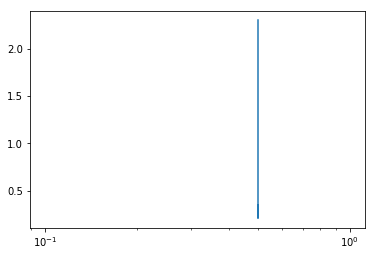

In [16]:
run.recorder.plot(skip_last=5)

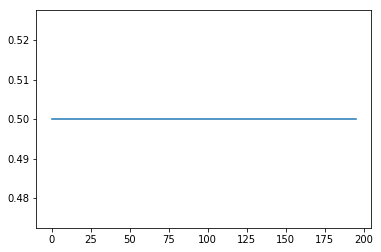

In [17]:
run.recorder.plot_lr()

In [0]:
create_learner??

In [0]:
torch.set_num_threads(2)

In [0]:
x_train,y_train,x_valid,y_valid = get_data()

In [0]:
def normalize_to(train, valid):
    m,s = train.mean(),train.std()
    return normalize(train, m, s), normalize(valid, m, s)

In [0]:
x_train,x_valid = normalize_to(x_train,x_valid)
train_ds,valid_ds = Dataset(x_train, y_train),Dataset(x_valid, y_valid)

In [23]:
x_train.mean(),x_train.std()

(tensor(3.0614e-05), tensor(1.))

In [0]:
nh,bs = 50,512
c = y_train.max().item()+1
loss_func = F.cross_entropy

data = DataBunch(*get_dls(train_ds, valid_ds, bs), c)

In [0]:
#export
class Lambda(nn.Module):
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x): return self.func(x)

def flatten(x):      return x.view(x.shape[0], -1)

In [0]:
def mnist_resize(x): return x.view(-1, 1, 28, 28) 

In [0]:
def get_cnn_model(data):
    return nn.Sequential(
        Lambda(mnist_resize),
        nn.Conv2d( 1, 8, 5, padding=2,stride=2), nn.ReLU(), #14
        nn.Conv2d( 8,16, 3, padding=1,stride=2), nn.ReLU(), # 7
        nn.Conv2d(16,32, 3, padding=1,stride=2), nn.ReLU(), # 4
        nn.Conv2d(32,32, 3, padding=1,stride=2), nn.ReLU(), # 2
        nn.AdaptiveAvgPool2d(1),
        Lambda(flatten),
        nn.Linear(32,data.c)
    )

In [0]:
model = get_cnn_model(data)

In [0]:
cbfs = [Recorder, partial(AvgStatsCallback,accuracy)]

In [0]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [31]:
%time run.fit(1, learn)

train: [2.2877003125, tensor(0.1686)]
valid: [2.091505078125, tensor(0.2301)]
CPU times: user 5.34 s, sys: 264 ms, total: 5.6 s
Wall time: 4.79 s



# CUDA
This took a long time to run, so it's time to use a GPU. A simple Callback can make sure the model, inputs and targets are all on the same device.

In [0]:
# Somewhat more flexible way
device = torch.device('cuda',0)

In [0]:
class CudaCallback(Callback):
    def __init__(self,device): self.device=device
    def begin_fit(self): self.model.to(self.device)
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.to(self.device),self.yb.to(self.device)

In [0]:
# Somewhat less flexible, but quite convenient
torch.cuda.set_device(device)

In [0]:
#export
class CudaCallback(Callback):
    def begin_fit(self): self.model.cuda()
    def begin_batch(self): self.run.xb,self.run.yb = self.xb.cuda(),self.yb.cuda()

In [0]:
cbfs.append(CudaCallback)

In [0]:
model = get_cnn_model(data)

In [0]:
opt = optim.SGD(model.parameters(), lr=0.4)
learn = Learner(model, opt, loss_func, data)
run = Runner(cb_funcs=cbfs)

In [39]:
%time run.fit(3, learn)

train: [2.2315071875, tensor(0.2027, device='cuda:0')]
valid: [1.63661474609375, tensor(0.4498, device='cuda:0')]
train: [0.760858046875, tensor(0.7534, device='cuda:0')]
valid: [0.297306591796875, tensor(0.9080, device='cuda:0')]
train: [0.22968818359375, tensor(0.9321, device='cuda:0')]
valid: [0.15567633056640626, tensor(0.9598, device='cuda:0')]
CPU times: user 5.32 s, sys: 1.39 s, total: 6.72 s
Wall time: 9.64 s


# Refactor model

First we can regroup all the conv/relu in a single function:

In [0]:
def conv2d(ni, nf, ks=3, stride=2):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), nn.ReLU())

In [0]:
#export
class BatchTransformXCallback(Callback):
    _order=2
    def __init__(self, tfm): self.tfm = tfm
    def begin_batch(self): self.run.xb = self.tfm(self.xb)

def view_tfm(*size):
    
    def _inner(x): return x.view(*((-1,)+size))
    return _inner

In [0]:
mnist_view = view_tfm(1,28,28) 
cbfs.append(partial(BatchTransformXCallback, mnist_view))

In [0]:
nfs = [8,16,32,32]


With the AdaptiveAvgPool, this model can now work on any size input:

In [0]:
def get_cnn_layers(data, nfs):
    nfs = [1] + nfs
    return [
        conv2d(nfs[i], nfs[i+1], 5 if i==0 else 3) # 5x5 filters why??
        for i in range(len(nfs)-1)
    ] + [nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def get_cnn_model(data, nfs): return nn.Sequential(*get_cnn_layers(data, nfs)) #what does adaptivepool

In [0]:
#export
def get_runner(model, data, lr=0.6, cbs=None, opt_func=None, loss_func = nn.functional.cross_entropy):
    if opt_func is None: opt_func = optim.SGD
    opt = opt_func(model.parameters(), lr=lr)
    learn = Learner(model, opt, loss_func, data)
    return learn, Runner(cb_funcs=listify(cbs))

In [46]:
model

Sequential(
  (0): Lambda()
  (1): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (2): ReLU()
  (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (4): ReLU()
  (5): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (6): ReLU()
  (7): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (8): ReLU()
  (9): AdaptiveAvgPool2d(output_size=1)
  (10): Lambda()
  (11): Linear(in_features=32, out_features=10, bias=True)
)

In [47]:
run.fit(3, learn)

train: [0.154713505859375, tensor(0.9545, device='cuda:0')]
valid: [0.1335619873046875, tensor(0.9607, device='cuda:0')]
train: [0.12086650390625, tensor(0.9641, device='cuda:0')]
valid: [0.10016182861328125, tensor(0.9727, device='cuda:0')]
train: [0.09850615234375, tensor(0.9703, device='cuda:0')]
valid: [0.10729195556640625, tensor(0.9702, device='cuda:0')]


# Hooks
**Manual insertion**

Let's say we want to do some telemetry, and want the mean and standard deviation of each activations in the model. First we can do it manually like this:

In [0]:
class SequentialModel(nn.Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)
        self.act_means = [[] for _ in layers]
        self.act_stds  = [[] for _ in layers]
        
    def __call__(self, x):
        for i,l in enumerate(self.layers):
            x = l(x)
            with torch.no_grad():
                self.act_means[i].append(x.data.mean())
                self.act_stds [i].append(x.data.std ())
        return x
    
    def __iter__(self): return iter(self.layers)

In [0]:
model =  SequentialModel(*get_cnn_layers(data, nfs))
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [50]:
run.fit(2, learn)

train: [2.09264328125, tensor(0.2419, device='cuda:0')]
valid: [1.549035546875, tensor(0.4351, device='cuda:0')]
train: [0.4785037109375, tensor(0.8514, device='cuda:0')]
valid: [0.187706884765625, tensor(0.9458, device='cuda:0')]


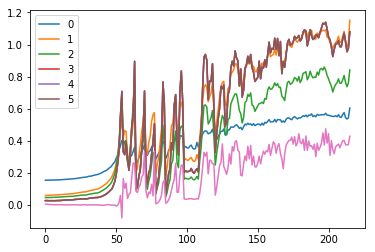

In [51]:
for l in model.act_means: plt.plot(l)
plt.legend(range(6));

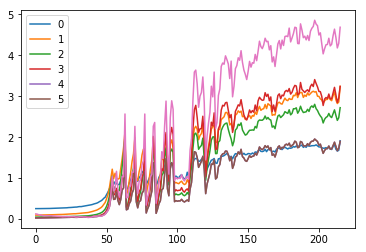

In [52]:
for l in model.act_stds: plt.plot(l)
plt.legend(range(6));

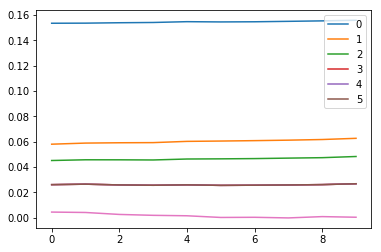

In [53]:
for l in model.act_means: plt.plot(l[:10])
plt.legend(range(6));

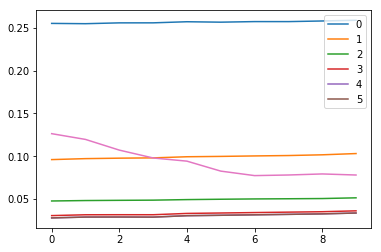

In [54]:
for l in model.act_stds: plt.plot(l[:10])
plt.legend(range(6));

**Pytorch hooks**

Hooks are PyTorch object you can add to any nn.Module. A hook will be called when a layer, it is registered to, is executed during the forward pass (forward hook) or the backward pass (backward hook).

Hooks don't require us to rewrite the model.


In [0]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [0]:
act_means = [[] for _ in model]
act_stds  = [[] for _ in model]

A hook is attached to a layer, and needs to have a function that takes three arguments: module, input, output. Here we store the mean and std of the output in the correct position of our list.

In [0]:
def append_stats(i, mod, inp, outp):
    act_means[i].append(outp.data.mean())
    act_stds [i].append(outp.data.std())

In [0]:
for i,m in enumerate(model): m.register_forward_hook(partial(append_stats, i))

In [59]:
run.fit(2, learn)

train: [1.94287109375, tensor(0.3133, device='cuda:0')]
valid: [0.9707455078125, tensor(0.7134, device='cuda:0')]
train: [0.37225453125, tensor(0.8865, device='cuda:0')]
valid: [0.1615411376953125, tensor(0.9522, device='cuda:0')]


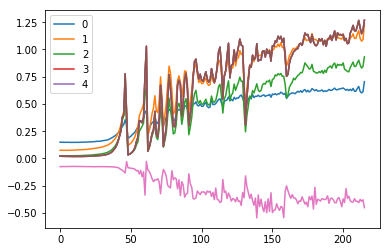

In [60]:
for o in act_means: plt.plot(o)
plt.legend(range(5));


**Hook class**


We can refactor this in a Hook class. It's very important to remove the hooks when they are deleted, otherwise there will be references kept and the memory won't be properly released when your model is deleted.

In [0]:
#export
def children(m): return list(m.children())

class Hook():
    def __init__(self, m, f): self.hook = m.register_forward_hook(partial(f, self))
    def remove(self): self.hook.remove()
    #__del__ is called automatically when python wants to clear some memory
    def __del__(self): self.remove()

def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[])
    means,stds = hook.stats
    means.append(outp.data.mean())
    stds .append(outp.data.std())

In [0]:
model = get_cnn_model(data, nfs)
learn,run = get_runner(model, data, lr=0.5, cbs=cbfs)

In [63]:
children(model[:4])

[Sequential(
   (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 ), Sequential(
   (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
   (1): ReLU()
 )]

In [0]:
hooks = [Hook(l, append_stats) for l in children(model[:4])]

In [65]:
run.fit(2, learn)

train: [2.02333953125, tensor(0.3037, device='cuda:0')]
valid: [0.688990869140625, tensor(0.7891, device='cuda:0')]
train: [0.4938069921875, tensor(0.8465, device='cuda:0')]
valid: [0.2053432861328125, tensor(0.9409, device='cuda:0')]


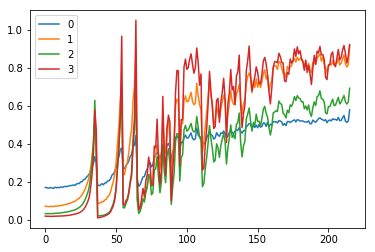

In [66]:
for h in hooks:
    plt.plot(h.stats[0])
    h.remove()
plt.legend(range(4));


# A Hooks class

Let's design our own class that can contain a list of objects. It will behave a bit like a numpy array in the sense that we can index into it via:

1.a single index
2.a slice (like 1:5)
3.a list of indices
4.a mask of indices ([True,False,False,True,...])
The __iter__ method is there to be able to do things like for x in ....

In [0]:
#a class to show behaviour of a typical list 
class ListContainer():
    def __init__(self, items): self.items = listify(items)
    def __getitem__(self, idx):
        if isinstance(idx, (int,slice)): return self.items[idx]
        if isinstance(idx[0],bool):
            assert len(idx)==len(self) # bool mask
            return [o for m,o in zip(idx,self.items) if m]
        return [self.items[i] for i in idx]
    def __len__(self): return len(self.items)
    def __iter__(self): return iter(self.items)
    def __setitem__(self, i, o): self.items[i] = o
    def __delitem__(self, i): del(self.items[i])
    def __repr__(self):
        res = f'{self.__class__.__name__} ({len(self)} items)\n{self.items[:10]}'
        if len(self)>10: res = res[:-1]+ '...]'
        return res

In [68]:
ListContainer(range(10))

ListContainer (10 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [69]:
ListContainer(range(100))

ListContainer (100 items)
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9...]

In [70]:
t = ListContainer(range(10))
t[[1,2]], t[[False]*8 + [True,False]]

([1, 2], [8])

We can use it to write a Hooks class that contains several hooks. We will also use it in the next notebook as a container for our objects in the data block API.

In [0]:
from torch.nn import init

class Hooks(ListContainer):
    def __init__(self, ms, f): super().__init__([Hook(m, f) for m in ms])
    def __enter__(self, *args): return self
    def __exit__ (self, *args): self.remove() #__exit__ is called when we use "with"
    def __del__(self): self.remove()

    def __delitem__(self, i):
        self[i].remove()
        super().__delitem__(i)
        
    def remove(self):
        for h in self: h.remove()

In [0]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [73]:
hooks = Hooks(model, append_stats)
len(hooks)

7

In [74]:
hooks = Hooks(model[:4], append_stats)
len(hooks)

4

In [0]:
hooks.remove()

In [0]:
x,y = next(iter(data.train_dl))
x = mnist_resize(x).cuda()

In [77]:
x.mean(),x.std()

(tensor(-0.0026, device='cuda:0'), tensor(0.9978, device='cuda:0'))

In [78]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.2609, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.5324, device='cuda:0', grad_fn=<StdBackward0>))

In [0]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [80]:
p = model[0](x)
p.mean(),p.std()

(tensor(0.3986, device='cuda:0', grad_fn=<MeanBackward0>),
 tensor(0.9156, device='cuda:0', grad_fn=<StdBackward0>))

train: [1.8239453125, tensor(0.3790, device='cuda:0')]
valid: [0.541347119140625, tensor(0.8275, device='cuda:0')]
train: [0.30752580078125, tensor(0.9088, device='cuda:0')]
valid: [0.1589341064453125, tensor(0.9531, device='cuda:0')]


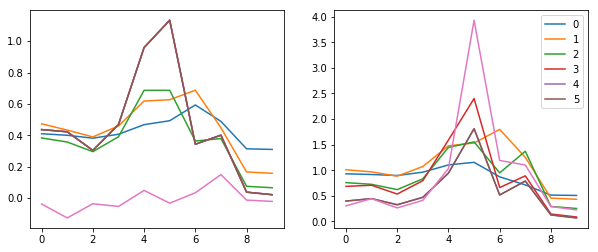

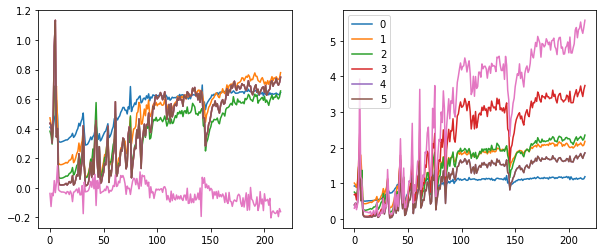

In [81]:
with Hooks(model, append_stats) as hooks:
    run.fit(2, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(6));


**Other statistics**

Let's store more than the means and stds and plot histograms of our activations now.

In [0]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,0,10)) #histc isn't implemented on the GPU

In [0]:
model = get_cnn_model(data, nfs).cuda()
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

In [0]:
for l in model:
    if isinstance(l, nn.Sequential):
        init.kaiming_normal_(l[0].weight)
        l[0].bias.data.zero_()

In [85]:
with Hooks(model, append_stats) as hooks: run.fit(1, learn)

train: [2.21935125, tensor(0.2235, device='cuda:0')]
valid: [1.643728125, tensor(0.4585, device='cuda:0')]


In [0]:
# Thanks to @ste for initial version of histgram plotting code
def get_hist(h): return torch.stack(h.stats[2]).t().float().log1p()

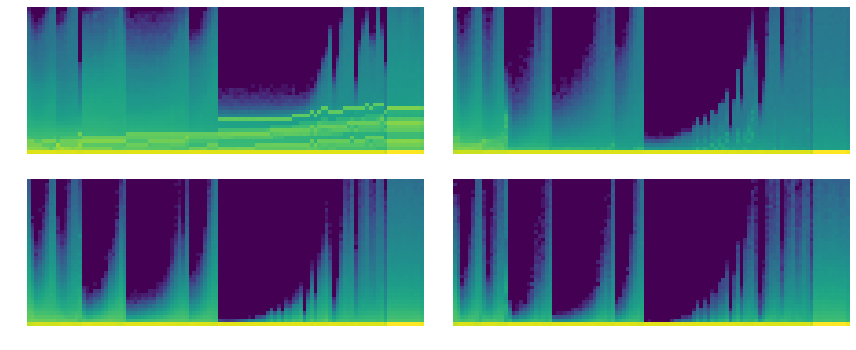

In [87]:
fig,axes = plt.subplots(2,2, figsize=(12,5))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [88]:
len(hooks)

7

In [0]:
# layer_num = 0
# stat_no = 2 #for hist

# hooks[layer_num].stats[0][iter_no]

In [91]:
len(hooks[0].stats[2]),hooks[0].stats[2][0].shape

(108, torch.Size([40]))

In [92]:
torch.stack(hooks[0].stats[2]).shape #this causes the currently 108 long list to stack in on tensor with shape 108,40 

torch.Size([108, 40])

In [0]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[:2].sum(0)/h1.sum(0) # what % are extremely close to zero

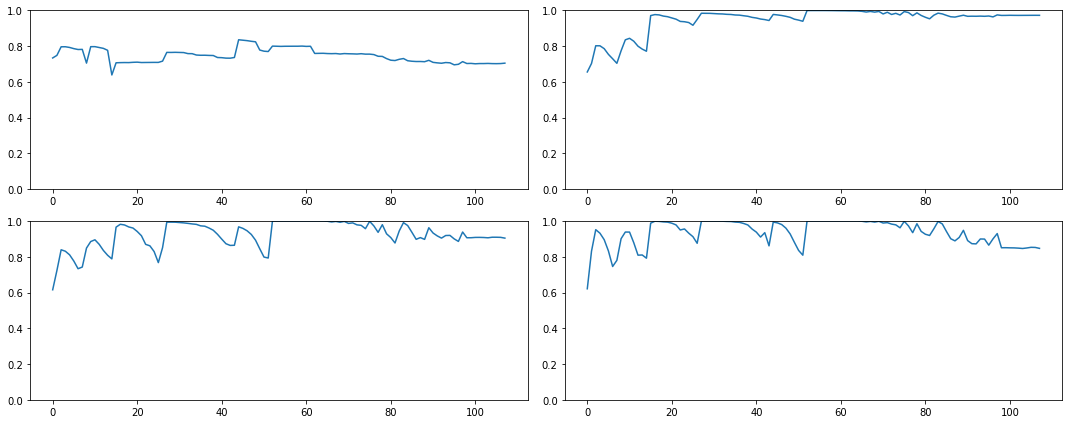

In [94]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

**Generalized ReLU**

Now let's use our model with a generalized ReLU that can be shifted and with maximum value.

In [0]:
#export
def get_cnn_layers(data, nfs, layer, **kwargs):
    nfs = [1] + nfs
    return [layer(nfs[i], nfs[i+1], 5 if i==0 else 3, **kwargs)
            for i in range(len(nfs)-1)] + [
        nn.AdaptiveAvgPool2d(1), Lambda(flatten), nn.Linear(nfs[-1], data.c)]

def conv_layer(ni, nf, ks=3, stride=2, **kwargs):
    return nn.Sequential(
        nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride), GeneralRelu(**kwargs))

class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak,self.sub,self.maxv = leak,sub,maxv

    def forward(self, x): 
        x = F.leaky_relu(x,self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    for l in m:
        if isinstance(l, nn.Sequential):
            f(l[0].weight, a=0.1)
            l[0].bias.data.zero_()

def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [0]:
def append_stats(hook, mod, inp, outp):
    if not hasattr(hook,'stats'): hook.stats = ([],[],[])
    means,stds,hists = hook.stats
    means.append(outp.data.mean().cpu())
    stds .append(outp.data.std().cpu())
    hists.append(outp.data.cpu().histc(40,-7,7))

In [0]:
model =  get_cnn_model(data, nfs, conv_layer, leak=0.1, sub=0.4, maxv=6.)
init_cnn(model)
learn,run = get_runner(model, data, lr=0.9, cbs=cbfs)

train: [0.477925390625, tensor(0.8524, device='cuda:0')]
valid: [0.15495028076171874, tensor(0.9535, device='cuda:0')]


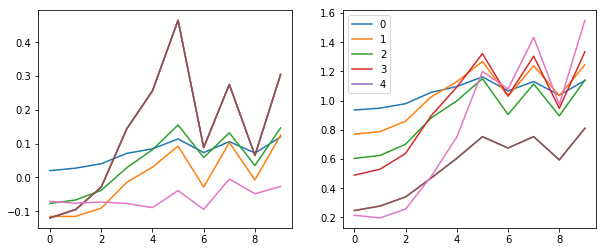

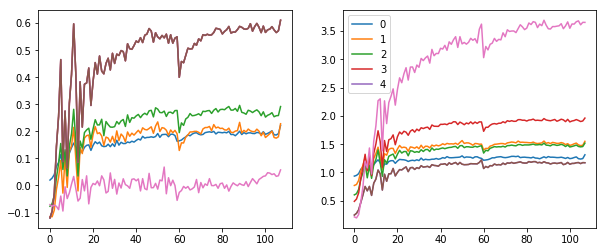

In [98]:
with Hooks(model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(5));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks:
        ms,ss,hi = h.stats
        ax0.plot(ms)
        ax1.plot(ss)
    plt.legend(range(5));

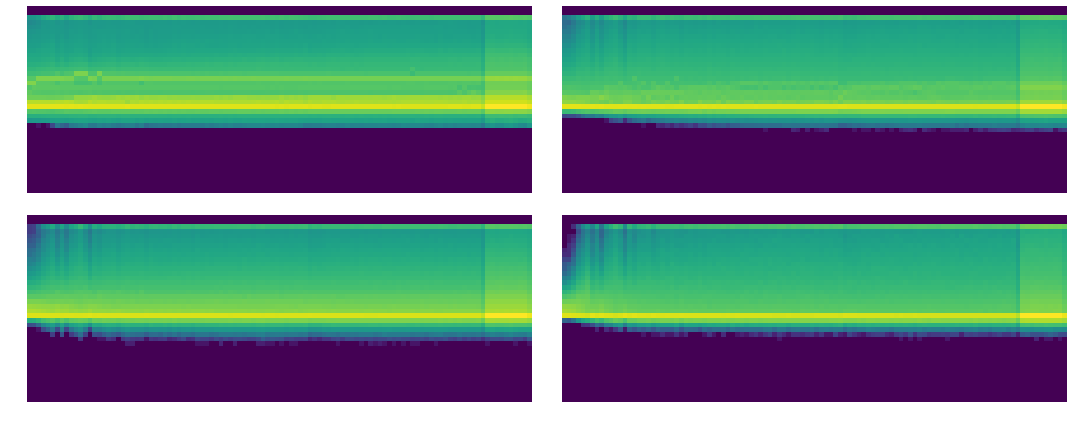

In [99]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.imshow(get_hist(h), origin='lower')
    ax.axis('off')
plt.tight_layout()

In [0]:
def get_min(h):
    h1 = torch.stack(h.stats[2]).t().float()
    return h1[19:22].sum(0)/h1.sum(0)

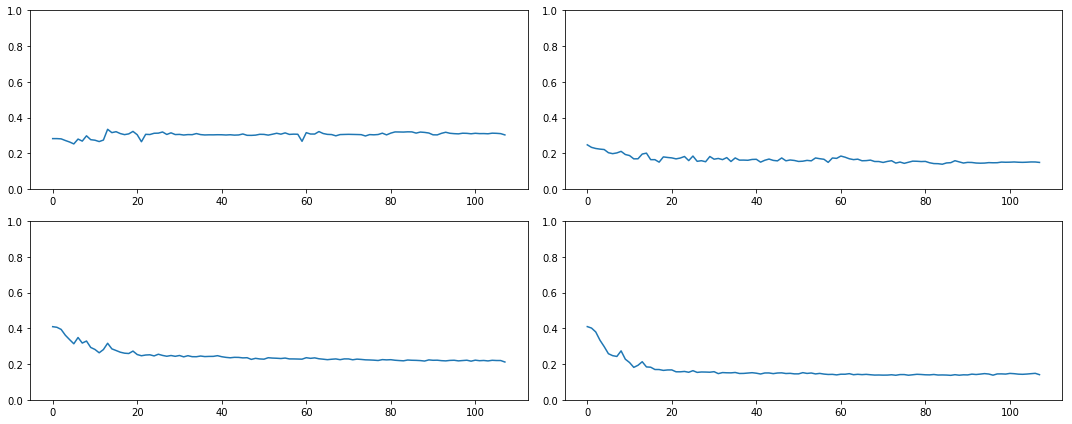

In [101]:
fig,axes = plt.subplots(2,2, figsize=(15,6))
for ax,h in zip(axes.flatten(), hooks[:4]):
    ax.plot(get_min(h))
    ax.set_ylim(0,1)
plt.tight_layout()

In [0]:

#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [0]:
sched = combine_scheds([0.5, 0.5], [sched_cos(0.2, 1.), sched_cos(1., 0.1)])

In [0]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs+[partial(ParamScheduler,'lr', sched)])

In [105]:
run.fit(8, learn)

train: [0.998614296875, tensor(0.6884, device='cuda:0')]
valid: [0.264144287109375, tensor(0.9233, device='cuda:0')]
train: [0.30558611328125, tensor(0.9074, device='cuda:0')]
valid: [0.2124568115234375, tensor(0.9406, device='cuda:0')]
train: [0.5093813671875, tensor(0.8458, device='cuda:0')]
valid: [0.2224815185546875, tensor(0.9329, device='cuda:0')]
train: [0.14591650390625, tensor(0.9551, device='cuda:0')]
valid: [0.098415771484375, tensor(0.9720, device='cuda:0')]
train: [0.08521873046875, tensor(0.9732, device='cuda:0')]
valid: [0.084614794921875, tensor(0.9742, device='cuda:0')]
train: [0.0615323681640625, tensor(0.9813, device='cuda:0')]
valid: [0.07422587280273438, tensor(0.9779, device='cuda:0')]
train: [0.0452511962890625, tensor(0.9862, device='cuda:0')]
valid: [0.06530254516601562, tensor(0.9812, device='cuda:0')]
train: [0.0367850390625, tensor(0.9893, device='cuda:0')]
valid: [0.06406543579101563, tensor(0.9826, device='cuda:0')]



# Batchnorm
**Custom**

Let's start by building our own BatchNorm layer from scratch.

In [0]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        # NB: pytorch bn mom is opposite of what you'd expect
        self.mom,self.eps = mom,eps
        self.mults = nn.Parameter(torch.ones (nf,1,1))
        self.adds  = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars',  torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))

    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var ((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_ (v, self.mom)
        return m,v
        
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m,v = self.update_stats(x)
        else: m,v = self.means,self.vars
        x = (x-m) / (v+self.eps).sqrt()
        return x*self.mults + self.adds

In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    # No bias needed if using bn
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(BatchNorm(nf))
    return nn.Sequential(*layers)

In [0]:
#export
def init_cnn_(m, f):
    if isinstance(m, nn.Conv2d):
        f(m.weight, a=0.1)
        if getattr(m, 'bias', None) is not None: m.bias.data.zero_()
    for l in m.children(): init_cnn_(l, f)

def init_cnn(m, uniform=False):
    f = init.kaiming_uniform_ if uniform else init.kaiming_normal_
    init_cnn_(m, f)

def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, uniform=False, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model, uniform=uniform)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs)

train: [0.5105745703125, tensor(0.8593, device='cuda:0')]
valid: [0.3494212890625, tensor(0.8920, device='cuda:0')]


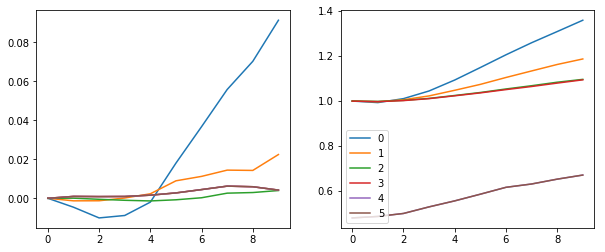

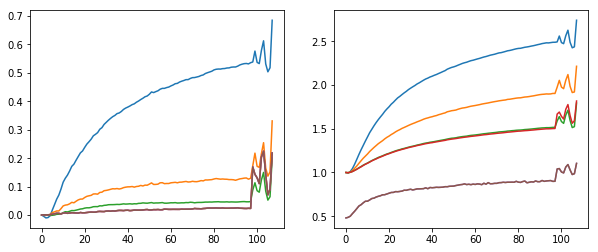

In [110]:
with Hooks(learn.model, append_stats) as hooks:
    run.fit(1, learn)
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss,_ = h.stats
        ax0.plot(ms[:10])
        ax1.plot(ss[:10])
        h.remove()
    plt.legend(range(6));
    
    fig,(ax0,ax1) = plt.subplots(1,2, figsize=(10,4))
    for h in hooks[:-1]:
        ms,ss,_ = h.stats
        ax0.plot(ms)
        ax1.plot(ss)

In [0]:
learn,run = get_learn_run(nfs, data, 1.0, conv_layer, cbs=cbfs)

In [112]:
%time run.fit(3, learn)

train: [0.5150808984375, tensor(0.8501, device='cuda:0')]
valid: [0.26751875, tensor(0.9170, device='cuda:0')]
train: [0.20421677734375, tensor(0.9383, device='cuda:0')]
valid: [0.17951123046875, tensor(0.9456, device='cuda:0')]
train: [0.147769189453125, tensor(0.9548, device='cuda:0')]
valid: [0.1487054931640625, tensor(0.9574, device='cuda:0')]
CPU times: user 3.78 s, sys: 738 ms, total: 4.51 s
Wall time: 4.54 s


**Builtin batchnorm**

In [0]:
#export
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 1., conv_layer, cbs=cbfs)

In [115]:
%time run.fit(3, learn)

train: [0.4104448828125, tensor(0.8827, device='cuda:0')]
valid: [0.1278691162109375, tensor(0.9608, device='cuda:0')]
train: [0.101286494140625, tensor(0.9696, device='cuda:0')]
valid: [0.09841199340820313, tensor(0.9696, device='cuda:0')]
train: [0.0749332568359375, tensor(0.9767, device='cuda:0')]
valid: [0.07629435424804687, tensor(0.9772, device='cuda:0')]
CPU times: user 3.36 s, sys: 629 ms, total: 3.98 s
Wall time: 4.01 s


**With scheduler**

Now let's add the usual warm-up/annealing.

In [0]:
sched = combine_scheds([0.3, 0.7], [sched_lin(0.6, 2.), sched_lin(2., 0.1)])

In [0]:
learn,run = get_learn_run(nfs, data, 0.9, conv_layer, cbs=cbfs
                          +[partial(ParamScheduler,'lr', sched)])

In [118]:
run.fit(8, learn)

train: [0.5469051171875, tensor(0.8479, device='cuda:0')]
valid: [0.2058943603515625, tensor(0.9341, device='cuda:0')]
train: [0.114663828125, tensor(0.9652, device='cuda:0')]
valid: [0.14848341064453124, tensor(0.9573, device='cuda:0')]
train: [0.0784251953125, tensor(0.9753, device='cuda:0')]
valid: [0.10215294189453125, tensor(0.9718, device='cuda:0')]
train: [0.0536793701171875, tensor(0.9829, device='cuda:0')]
valid: [0.07793644409179687, tensor(0.9760, device='cuda:0')]
train: [0.0387386962890625, tensor(0.9882, device='cuda:0')]
valid: [0.05210223388671875, tensor(0.9856, device='cuda:0')]
train: [0.02957352783203125, tensor(0.9907, device='cuda:0')]
valid: [0.05096993713378906, tensor(0.9847, device='cuda:0')]
train: [0.02278833251953125, tensor(0.9933, device='cuda:0')]
valid: [0.047660794067382814, tensor(0.9862, device='cuda:0')]
train: [0.01811787353515625, tensor(0.9953, device='cuda:0')]
valid: [0.04591546936035156, tensor(0.9867, device='cuda:0')]


# Fix small batch sizes
**What's the problem?**

When we compute the statistics (mean and std) for a BatchNorm Layer on a small batch, it is possible that we get a standard deviation very close to 0. because there aren't many samples (the variance of one thing is 0. since it's equal to its mean).

In [0]:
data = DataBunch(*get_dls(train_ds, valid_ds, 2), c)

In [0]:
def conv_layer(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride = stride, bias = not bn), GeneralRelu(**kwargs)]
    if bn: layers.append(nn.BatchNorm2d(nf, eps=1e-5, momentum=0.1))
    return nn.Sequential(*layers)

In [0]:
learn, run = get_learn_run(nfs, data, 0.4, conv_layer, cbs=cbfs)

In [123]:
%time run.fit(1, learn)

train: [1.51932015625, tensor(0.5385, device='cuda:0')]
valid: [180.3336125, tensor(0.8374, device='cuda:0')]
CPU times: user 1min 33s, sys: 2.65 s, total: 1min 36s
Wall time: 1min 37s


**Running Batch Norm**


To solve this problem we introduce a Running BatchNorm that uses smoother running mean and variance for the mean and std.

In [0]:
class RunningBatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.zeros(nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('sums', torch.zeros(1,nf,1,1))
        self.register_buffer('sqrs', torch.zeros(1,nf,1,1))
        self.register_buffer('count', tensor(0.))
        self.register_buffer('factor', tensor(0.))
        self.register_buffer('offset', tensor(0.))
        self.batch = 0

    def update_stats(self, x):
        bs, nc, *_ = x.shape
        self.sums.detach_()
        self.sqrs.detach_()
        dims = (0, 2, 3)
        s = x.sum(dims, keepdim = True)
        ss = (x*x).sum(dims, keepdim = True)
        c = s.new_tensor(x.numel()/nc)
        mom1 = s.new_tensor(1 - (1 - self.mom)/math.sqrt(bs-1))
        self.sums.lerp_(s, mom1)
        self.sqrs.lerp_(ss, mom1)
        self.count.lerp_(c, mom1)
        self.batch += bs
        means = self.sums/self.count
        varns = (self.sqrs/self.count).sub_(means*means)
        if bool(self.batch<20): varns.clamp_min_(0.01)
        self.factor = self.mults / (varns+self.eps).sqrt()
        self.offset = self.adds - means*self.factor

    def forward(self, x):
        if self.training: self.update_stats(x)
        return x*self.factor + self.offset



In [0]:
def conv_rbn(ni, nf, ks=3, stride=2, bn=True, **kwargs):
    layers = [nn.Conv2d(ni, nf, ks, padding=ks//2, stride=stride, bias=not bn),
              GeneralRelu(**kwargs)]
    if bn: layers.append(RunningBatchNorm(nf))
    return nn.Sequential(*layers)

In [0]:
learn,run = get_learn_run(nfs, data, 0.4, conv_rbn, cbs=cbfs+[partial(ParamScheduler,'lr',sched_lin(1., 0.2))])

In [157]:
%time run.fit(1, learn)

train: [2.3740165625, tensor(0.1040, device='cuda:0')]
valid: [2.3305578125, tensor(0.0961, device='cuda:0')]
CPU times: user 3min 18s, sys: 4.12 s, total: 3min 22s
Wall time: 3min 24s
